# LSTM Sarcasm Detection (Baseline vs GloVe)

This notebook trains and compares:
- **Baseline LSTM** with randomly initialized embeddings
- **Improved LSTM** initialized with **GloVe-100d**, plus dropout + early stopping

Dataset: `Sarcasm_Headlines_Dataset.json`  
GloVe: `glove.6B.100d.txt` (downloaded if missing)


In [1]:
import os
import shutil
import subprocess
import random
import string
from collections import Counter
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 1) GloVe download (only if missing)


In [2]:
# Avoid re-downloading 822MB every run
GLOVE_TXT = "glove.6B.100d.txt"
GLOVE_ZIP = "glove.6B.zip"
URL = "https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip"

# 1) Ensure unzip exists (WSL/Linux)
if shutil.which("unzip") is None:
    print("Missing 'unzip'. In WSL/Linux, install it with:")
    print("  sudo apt update && sudo apt install -y unzip")
    raise RuntimeError("unzip not found")

# 2) Download if missing (shows progress)
if os.path.exists(GLOVE_TXT):
    print("GloVe already present:", GLOVE_TXT)
else:
    if not os.path.exists(GLOVE_ZIP):
        print("Downloading GloVe (~822MB)... this may take a few minutes.")
        subprocess.run(["wget", "--progress=dot:giga", URL, "-O", GLOVE_ZIP], check=True)
    else:
        print("Zip already present, skipping download:", GLOVE_ZIP)

    # 3) Extract only what we need
    print("Extracting", GLOVE_TXT, "...")
    subprocess.run(["unzip", "-o", GLOVE_ZIP, GLOVE_TXT], check=True)
    print("Done.")


GloVe already present: glove.6B.100d.txt


## 2) Data loading + preprocessing


In [3]:
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def tokenize(text: str):
    return text.lower().translate(PUNCT_TABLE).split()

def load_data(filepath="Sarcasm_Headlines_Dataset.json"):
    df = pd.read_json(filepath, lines=True)
    texts = df["headline"].astype(str)
    labels = df["is_sarcastic"].astype(int)
    return texts, labels

def build_vocab(texts):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for w, _ in counter.most_common():
        vocab[w] = len(vocab)
    return vocab

def text_to_ids(text, vocab):
    return [vocab.get(tok, vocab["<UNK>"]) for tok in tokenize(text)]

def pad_to_max(ids, max_len, pad_id=0):
    ids = ids[:max_len]
    ln = len(ids)
    if ln < max_len:
        ids = ids + [pad_id] * (max_len - ln)
    return ids, ln

MAX_LEN = 20


In [4]:
texts, labels = load_data()
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Reset indices so misclassification mapping stays correct
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

vocab = build_vocab(X_train)
pad_id = vocab["<PAD>"]
print("Vocab size:", len(vocab))

def encode_texts(series, vocab, max_len=MAX_LEN):
    ids_list, lens_list = [], []
    for t in series:
        ids, ln = pad_to_max(text_to_ids(t, vocab), max_len, pad_id=pad_id)
        ids_list.append(ids)
        lens_list.append(ln)
    return (
        torch.tensor(ids_list, dtype=torch.long),
        torch.tensor(lens_list, dtype=torch.long),
    )

X_train_ids, X_train_lens = encode_texts(X_train, vocab)
X_test_ids,  X_test_lens  = encode_texts(X_test, vocab)

y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

def make_loaders(X_ids, X_lens, y, batch_size=64, val_split=0.1):
    ds = TensorDataset(X_ids, X_lens, y)
    val_size = int(len(ds) * val_split)
    train_size = len(ds) - val_size
    train_ds, val_ds = random_split(
        ds,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),
    )
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = make_loaders(X_train_ids, X_train_lens, y_train_t)
test_loader = DataLoader(TensorDataset(X_test_ids, X_test_lens, y_test_t), batch_size=64, shuffle=False)


Vocab size: 25545


## 3) Load GloVe + build embedding matrix


In [5]:
def load_glove(filepath, embedding_dim=100):
    emb = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split()
            w = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            if vec.shape[0] == embedding_dim:
                emb[w] = vec
    return emb

def build_embedding_matrix(vocab, glove, embedding_dim=100):
    mat = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim)).astype(np.float32)
    mat[vocab["<PAD>"]] = 0.0  # PAD should be zeros
    for w, idx in vocab.items():
        if w in ("<PAD>", "<UNK>"):
            continue
        vec = glove.get(w)
        if vec is not None:
            mat[idx] = vec
    return torch.tensor(mat, dtype=torch.float32)

glove = load_glove(GLOVE_TXT, embedding_dim=100)
embedding_tensor = build_embedding_matrix(vocab, glove, embedding_dim=100)
print("Embedding matrix:", embedding_tensor.shape)


Embedding matrix: torch.Size([25545, 100])


## 4) Models (Baseline vs GloVe)

We return **logits** (no sigmoid in the model) and use `BCEWithLogitsLoss` for stability.
We also use `pack_padded_sequence` so the LSTM ignores padding tokens.


In [6]:
class LSTMSarcasm(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=128, n_layers=2, dropout=0.2,
                 pretrained_embeddings=None, freeze_embeddings=False, pad_idx=0):
        super().__init__()
        if pretrained_embeddings is None:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        else:
            self.embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings, freeze=freeze_embeddings, padding_idx=pad_idx
            )

        self.lstm = nn.LSTM(
            input_size=self.embedding.embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)  # logits

    def forward(self, x_ids, x_lens):
        emb = self.embedding(x_ids)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, x_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        h_last = h_n[-1]
        h_last = self.dropout(h_last)
        return self.fc(h_last)  # logits


## 5) Training + evaluation


In [7]:
def train_model(model, train_loader, val_loader, lr=1e-3, weight_decay=0.0, epochs=10, patience=3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total = 0.0
        for xb, xl, yb in train_loader:
            xb, xl, yb = xb.to(device), xl.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb, xl)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total += loss.item()

        train_loss = total / len(train_loader)

        model.eval()
        val_total = 0.0
        with torch.no_grad():
            for xb, xl, yb in val_loader:
                xb, xl, yb = xb.to(device), xl.to(device), yb.to(device)
                logits = model(xb, xl)
                val_total += criterion(logits, yb).item()

        val_loss = val_total / len(val_loader)
        print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def predict(model, loader, threshold=0.5):
    model.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, xl, yb in loader:
            xb, xl = xb.to(device), xl.to(device)
            logits = model(xb, xl)
            p = torch.sigmoid(logits).cpu().numpy().reshape(-1)
            probs.extend(p)
            ys.extend(yb.numpy().reshape(-1))
    probs = np.array(probs)
    ys = np.array(ys)
    preds = (probs >= threshold).astype(int)
    return preds, probs, ys

def report_metrics(name, model):
    preds, probs, ys = predict(model, test_loader)
    acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds)
    rec = recall_score(ys, preds)
    f1 = f1_score(ys, preds)
    print(f"{name} | acc {acc:.4f} | prec {prec:.4f} | rec {rec:.4f} | f1 {f1:.4f}")

    cm = confusion_matrix(ys, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return preds, probs, ys


## 6) Train baseline vs improved


Epoch 01 | train 0.5280 | val 0.4285
Epoch 02 | train 0.3715 | val 0.3810
Epoch 03 | train 0.2614 | val 0.3797
Epoch 04 | train 0.1625 | val 0.4446
Epoch 05 | train 0.0963 | val 0.5139
Epoch 06 | train 0.0542 | val 0.6046
Early stopping.
Baseline (Random) | acc 0.8276 | prec 0.7892 | rec 0.8286 | f1 0.8084


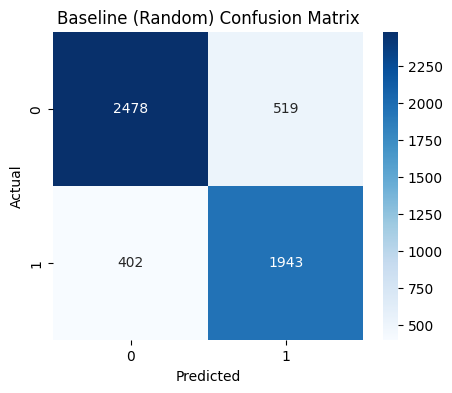

Epoch 01 | train 0.4600 | val 0.3574
Epoch 02 | train 0.2690 | val 0.3127
Epoch 03 | train 0.1642 | val 0.3295
Epoch 04 | train 0.0847 | val 0.4439
Epoch 05 | train 0.0441 | val 0.5015
Early stopping.
Improved (GloVe) | acc 0.8600 | prec 0.8882 | rec 0.7791 | f1 0.8301


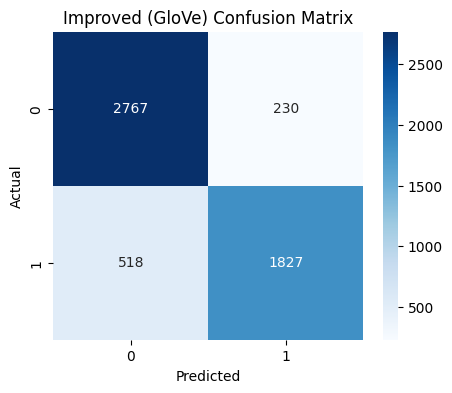

In [8]:
# Baseline: random embeddings (no weight decay, no early stopping needed but kept consistent)
baseline = LSTMSarcasm(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, n_layers=2, dropout=0.2, pretrained_embeddings=None)
baseline = train_model(baseline, train_loader, val_loader, lr=1e-3, weight_decay=0.0, epochs=10, patience=3)
preds_b, probs_b, ys = report_metrics("Baseline (Random)", baseline)

# Improved: GloVe init + weight decay + early stopping
improved = LSTMSarcasm(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, n_layers=2, dropout=0.2,
                      pretrained_embeddings=embedding_tensor, freeze_embeddings=False)
improved = train_model(improved, train_loader, val_loader, lr=1e-3, weight_decay=1e-7, epochs=10, patience=3)
preds_i, probs_i, ys = report_metrics("Improved (GloVe)", improved)


## 7) Error Analysis (false positives / false negatives)
One quick look at mistakes to see what kinds of headlines confuse the model.


In [9]:
def misclassified_texts(X_test_series, y_true, y_pred, k=5):
    fp_idx = np.where((y_pred == 1) & (y_true == 0))[0]
    fn_idx = np.where((y_pred == 0) & (y_true == 1))[0]
    fps = X_test_series.iloc[fp_idx].tolist()[:k]
    fns = X_test_series.iloc[fn_idx].tolist()[:k]
    return fps, fns

fps, fns = misclassified_texts(X_test, ys.astype(int), preds_i.astype(int), k=5)
print("False positives:")
for x in fps: print("-", x)
print("\nFalse negatives:")
for x in fns: print("-", x)


False positives:
- all about otters!
- americans finally found something to drink that's better than soda
- florida man sentenced for running over ducks with lawnmower
- apparently reese witherspoon likes j.crew as much as we do
- desperate dolphin mom seen helping her trapped baby breathe

False negatives:
- israeli soldiers open fire on palestinians carrying potentially dangerous injured friends
- learned sage points out that powerball not as much after taxes
- that show about the lady sheriff finally released on dvd
- gender of person in ronald mcdonald costume unclear
- trump maps out plan for first 100 days of not conceding election


## 8) Word importance (leave-one-out masking)
We estimate word importance by removing each word and measuring how much the model’s predicted sarcasm probability changes. Larger changes = more important.


In [10]:
import matplotlib.colors as mcolors
from IPython.display import HTML, display

def word_saliency_loo(model, text, vocab, max_len=MAX_LEN):
    """
    Leave-one-out word importance:
    importance(word_i) = |p(full) - p(text without word_i)|
    Normalized to [0, 1] per headline for coloring.
    """
    toks = tokenize(text)[:max_len]
    if not toks:
        return []

    p_full = predict_one(model, text)

    deltas = []
    for i in range(len(toks)):
        text_loo = " ".join(toks[:i] + toks[i+1:])
        p_loo = predict_one(model, text_loo)
        deltas.append(abs(p_full - p_loo))

    deltas = np.array(deltas, dtype=float)
    if deltas.max() > 0:
        deltas = deltas / deltas.max()

    return list(zip(toks, deltas.tolist()))

def highlight_words(word_scores):
    cmap = mcolors.LinearSegmentedColormap.from_list("imp", ["white", "red"])
    norm = mcolors.Normalize(vmin=0, vmax=1)
    spans = []
    for w, s in word_scores:
        color = mcolors.to_hex(cmap(norm(s)))
        spans.append(
            f'<span style="background:{color}; padding:2px 4px; margin:2px; border-radius:3px;">{w}</span>'
        )
    return " ".join(spans)

def predict_one(model, headline):
    ids, ln = pad_to_max(text_to_ids(headline, vocab), MAX_LEN, pad_id=pad_id)
    x = torch.tensor([ids], dtype=torch.long, device=device)
    l = torch.tensor([ln], dtype=torch.long, device=device)
    model.eval()
    with torch.no_grad():
        p = torch.sigmoid(model(x, l)).item()
    return p

def predict_and_show(model, headline):
    p = predict_one(model, headline)
    label = "Sarcastic" if p >= 0.5 else "Not Sarcastic"
    scores = word_saliency_loo(model, headline, vocab, max_len=MAX_LEN)
    display(HTML(f"<p><b>{label}</b> (p={p:.4f})</p><p>{highlight_words(scores)}</p>"))




## 9) Demo: Unseen Test Headlines
This section randomly samples one sarcastic and one non-sarcastic headline from the test split (unseen during training) and shows the model prediction + leave-one-out word importance.

In [ ]:
# pick 1 sarcastic + 1 non-sarcastic from TEST set (unseen during training)

rng = np.random.default_rng(SEED)

sar_idx = np.where(y_test.values == 1)[0]
non_idx = np.where(y_test.values == 0)[0]

i_sar = int(rng.choice(sar_idx))
i_non = int(rng.choice(non_idx))

print("=== Unseen test example: Non-sarcastic (y=0) ===")
print(X_test.iloc[i_non])
predict_and_show(improved, X_test.iloc[i_non])

print("\n=== Unseen test example: Sarcastic (y=1) ===")
print(X_test.iloc[i_sar])
predict_and_show(improved, X_test.iloc[i_sar])


=== Unseen test example: Non-sarcastic (y=0) ===
dems discuss dropping wasserman schultz



=== Unseen test example: Sarcastic (y=1) ===
nude aides huddled around trump assure him no one wearing wire


## 10) Try your own headline (edit + rerun)

This model was trained on Onion/HuffPost-style headlines, so it’s best at that genre.
On other writing styles, treat the result as a quick signal (not a definitive label).

**p** = model’s predicted probability that the headline is *sarcastic*.

In [12]:
# Edit this string and re-run the cell
headline = "Trump invades Greenland"
print("Baseline p:", predict_one(baseline, headline))
print("Improved  p:", predict_one(improved, headline))
predict_and_show(improved, headline)

Baseline p: 0.19043095409870148
Improved  p: 0.11823077499866486
